<h1>Solving Kaggle's Cats vs Dogs with Theano and Lasagne</h1>

The dataset consists of 25k labeled RGB .jpg images of cats and dogs of various resolutions. As a start, I decided to transform the original images into 100 * 100 grayscale images and train a convnet on them. 



In [1]:
import sys
import os
import csv
import numpy as np
import Image
import ImageOps
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle



# Convert all the image files in the given path into np arrays with dimensions suitable for DL with Theano
def jpg_to_nparray(path, img_size, grayscale = False):
    X = []
    Y = []
    counter = 0
    img_colors = 3

    for img_dir in os.listdir(path):

        # X
        img = Image.open(path+img_dir)
        img = ImageOps.fit(img, (img_size, img_size), Image.ANTIALIAS)
        
        if grayscale:
            img = ImageOps.grayscale(img)
            img_colors = 1


        img = np.asarray(img, dtype = 'float32') / 255.
        img = img.transpose(2,0,1).reshape(img_colors, img_size, img_size)
        X.append(img)

        # Y: 0 for cat, 1 for dog
        if "cat" in img_dir:
            Y.append(0)
        else:
            Y.append(1)


        # Printing
        counter+=1
        if counter%6000 == 0:
            print'processed images: ', counter

    X = np.asarray(X)
    Y = np.asarray(Y,dtype='int32')

    return (X,Y)



# Get ids of the images: we'll need them for generating the submission file for Kaggle
def get_ids(path):
    ids = np.array([],dtype = int)
    for str in os.listdir(path):
        ids = np.append(ids, int(str.partition(".")[0]))
    
    ids = np.array(ids, dtype = int)[...,None]
    return ids


        
        
def make_datasets(img_size, grayscale = False, labeled = 1):

    train_path = '/media/dima/Data/DATA_DL/cats_vs_dogs/train/'
    unlabeled_path = '/media/dima/Data/DATA_DL/cats_vs_dogs/test1/'

    if (labeled == 1 or labeled == 3):
        print 'Prosessing labeled images'

        X_train, Y_train = jpg_to_nparray(train_path, img_size, grayscale)

        # Patrtition into labeled training, validatin and test sets
        # Shuffle the examples, because they are in order in the original dataset with all cats being first
        rng_state = np.random.get_state()
        np.random.shuffle(X_train)
        np.random.set_state(rng_state)
        np.random.shuffle(Y_train)


        X_val = X_train[0:2999]
        Y_val = Y_train[0:2999]
        X_test = X_train[3000:4999]
        Y_test = Y_train[3000:4999]
        X_train = X_train[5000:24999]
        Y_train = Y_train[5000:24999]

        pickle.dump((X_train, Y_train, X_val, Y_val, X_test, Y_test), 
                    open('/media/dima/Data/DATA_DL/cats_vs_dogs/datasets_labeled_100.pkl','wb'))
    
    if (labeled == 2 or labeled == 3):
        print 'Prosessing unlabeled images'

        X_unlabeled, Y_unlabeled = jpg_to_nparray(unlabeled_path, img_size, grayscale)

        pickle.dump((X_unlabeled, Y_unlabeled), 
                    open('/media/dima/Data/DATA_DL/cats_vs_dogs/datasets_unlabeled_100.pkl','wb'))

<h2>Plotting one of the original pictures and the same picture after transformation</h2>


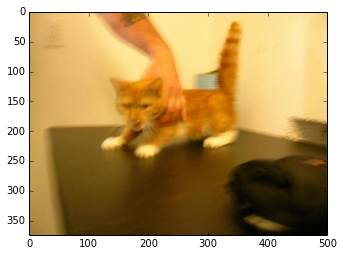

In [2]:
path = ('/media/dima/Data/DATA_DL/cats_vs_dogs/train/')
img = Image.open(path+os.listdir(path)[0])
plt.imshow(img)
plt.show()

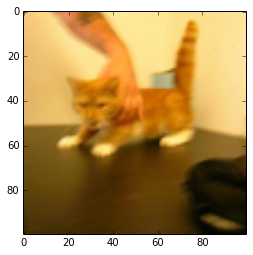

In [3]:
img = ImageOps.fit(img, (100, 100), Image.ANTIALIAS)
plt.imshow(img)
plt.show()

<h2>Function for initializing the convnet</h2>

The code below relies heavily on the <a href="http://lasagne.readthedocs.org/en/latest/user/tutorial.html#run-the-mnist-example">
lasagne MNIST tutorial</a>.

Convnet architecture:

* Input: 3x100x100
* Conv: 64  7x7 filters MaxPool: 2x2
* Conv: 128  5x5 filters
* Conv: 128  5x5 filters MaxPool: 2x2
* Conv: 128  5x5 filters
* Conv: 128  4x4 filters MaxPool: 2x2

* Fully-connected: 600 units, 30% dropout
* Output: 2 units, 50% dropout


In [4]:
import theano
import theano.tensor as T
import time
import lasagne


def build_cnn(input_var=None):

    # Input layer:
    network = lasagne.layers.InputLayer(shape=(None, 3, 100, 100),
                                        input_var=input_var)

    # Convolutional layer with 32 kernels of size 7x7. 
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(7, 7),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
    print(lasagne.layers.get_output_shape(network))

    # Max-pooling layer of factor 2 in both dimensions:
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    print(lasagne.layers.get_output_shape(network))

    # Convolution with 64 5x5 kernels:
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=64, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify)
    print(lasagne.layers.get_output_shape(network))

    # Max-pooling layer of factor 2 in both dimensions:
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    print(lasagne.layers.get_output_shape(network))

        
    # Convolution with 64 5x5 kernels:
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=64, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify)
    print(lasagne.layers.get_output_shape(network))

    # Convolution with 100 4x4 kernels:
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=100, filter_size=(4, 4),
            nonlinearity=lasagne.nonlinearities.rectify)
    print(lasagne.layers.get_output_shape(network))

    # Max-pooling layer of factor 2 in both dimensions:
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    print(lasagne.layers.get_output_shape(network))

    # A fully-connected layer of 400 units with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=400,
            nonlinearity=lasagne.nonlinearities.rectify)
    print(lasagne.layers.get_output_shape(network))

    
    # And, finally, the 2-unit output layer with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=2,
            nonlinearity=lasagne.nonlinearities.softmax)
    print(lasagne.layers.get_output_shape(network))

    return network


Using gpu device 0: GeForce GTX 850M (CNMeM is disabled)


<h2>Training the network and making predictions on Kaggle dataset</h2>

The network has been trained for 200 epochs, converging with ~12% test error after 150th epoch. L2 regularization is used.

In [ ]:
# A function from Lasagne MNIST tutorial for iterating minibatches of a given size
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]



def train_model(num_epochs=0, make_predictions = False):
    
    # Load the dataset
    print("Loading data...")
    X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(
        open(os.path.abspath('/media/dima/Data/DATA_DL/cats_vs_dogs/datasets_labeled_100.pkl'),'rb'))

    # Prepare Theano variables for inputs and targets
    input_var = T.tensor4('inputs')
    target_var = T.ivector('targets')

    # Initialize the model
    print("Building model and compiling functions...")
    network = build_cnn(input_var)
    

    # Create a loss expression for training
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
    loss = loss.mean()
    
    # Create L2 regularization and add it lo loss
    l2_regularization = lasagne.regularization.regularize_network_params(network, 
                                                                         lasagne.regularization.l2, 
                                                                         tags={'regularizable': True})*0.0003
    loss = loss + l2_regularization

    # Create update expressions for training
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(
            loss, params, learning_rate=0.005, momentum=0.8)

    # Create a loss expression for validation/testing. 
    # We do a deterministic forward pass through the network,
    # disabling dropout layers.
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                            target_var)
    test_loss = test_loss.mean()
    test_loss = test_loss + l2_regularization
    # As a bonus, also create an expression for the classification accuracy:
    test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                      dtype=theano.config.floatX)

    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    train_fn = theano.function([input_var, target_var], loss, updates=updates,  allow_input_downcast=True)

    # Compile a second function computing the validation loss and accuracy:
    val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

    # Compile a function for predicting unclassified images
    get_prediction = theano.function([input_var], [test_prediction])

    
    # Load saved weights
    #with np.load('cat_dog_100x100_colored_network_01_small_as_Grayscale_one.npz') as f:
         #param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    #lasagne.layers.set_all_param_values(network, param_values)

    batch_size = 128
    
    # The training loop.
    print("Starting training...")
    # We iterate over epochs:
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=True):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches += 1
    
        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, batch_size, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1
    
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100))
        
        # Save weights every 5 epochs
        if (epoch%2 == 0):
            np.savez('cat_dog_100x100_colored_network_01_small_as_Grayscale_one.npz', 
                     *lasagne.layers.get_all_param_values(network))



    # Compute and print the test error:
    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, batch_size, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        test_err += err
        test_acc += acc
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    print("  test accuracy:\t\t{:.2f} %".format(
        test_acc / test_batches * 100))



    if make_predictions:
        
        # Load the dataset
        print("Loading data...")
        X_unlabeled, y_unlabeled = pickle.load(
        open(os.path.abspath('/media/dima/Data/DATA_DL/cats_vs_dogs/datasets_unlabeled_100.pkl'),'rb'))

        predictions = np.array([],dtype = int)
        # Make predictions
        for batch in iterate_minibatches(X_unlabeled, y_unlabeled, batch_size, shuffle=False):
            inputs, targets = batch
            batch_predictions = np.array(get_prediction(inputs)).reshape(batch_size,2)
            batch_predictions = batch_predictions[:,1]>batch_predictions[:,0] 
            batch_predictions = np.array(batch_predictions, dtype= int)
            predictions = np.append(predictions, batch_predictions)
        predictions = np.array(predictions, dtype = int)[...,None]

        unlabeled_path = os.path.abspath('/media/dima/Data/DATA_DL/cats_vs_dogs/test1/')
        submission_ids = get_ids(unlabeled_path)

        submission_array = (np.append(submission_ids, predictions,axis = 1))
        np.savetxt("submission.csv", submission_array,  fmt='%d', delimiter=',', 
                   newline='\n', header='id,label', comments = '')
        print("Submission file saved")



    # Save the network weights to a file:
    np.savez('cat_dog_100x100_colored_network_01_small_as_Grayscale_one.npz', 
             *lasagne.layers.get_all_param_values(network))

    

if __name__ == '__main__':
    #make_datasets(100, grayscale = False)
    train_model(num_epochs = 100, make_predictions= False)

Loading data...
Building model and compiling functions...
(None, 32, 94, 94)
(None, 32, 47, 47)
(None, 64, 43, 43)
(None, 64, 21, 21)
(None, 64, 17, 17)
(None, 100, 14, 14)
(None, 100, 7, 7)
(None, 400)
(None, 2)
Starting training...
Epoch 1 of 100 took 106.444s
  training loss:		0.969935
  validation loss:		0.956148
  validation accuracy:		60.22 %
Epoch 2 of 100 took 108.888s
  training loss:		0.950513
  validation loss:		0.927805
  validation accuracy:		62.70 %
Epoch 3 of 100 took 110.544s
  training loss:		0.932323
  validation loss:		0.915218
  validation accuracy:		63.69 %
Epoch 4 of 100 took 110.655s
  training loss:		0.915475
  validation loss:		0.913838
  validation accuracy:		63.11 %
Epoch 5 of 100 took 110.468s
  training loss:		0.897458
  validation loss:		0.877923
  validation accuracy:		66.61 %
Epoch 6 of 100 took 110.418s
  training loss:		0.884534
  validation loss:		0.863145
  validation accuracy:		68.34 %
Epoch 7 of 100 took 110.379s
  training loss:		0.871919
  valida

In [ ]:
#X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(
       # open(os.path.abspath('/media/dima/Data/DATA_DL/cats_vs_dogs/datasets_labeled_100.pkl'),'rb'))


In [ ]:
import Image
import numpy as np

data = (X_train[1])
data.astype(dtype=np.uint8)
data.reshape(100,100,3)

img = Image.fromarray(data, 'RGB')
img.save('my.png')

X_train[1].shape




In [ ]:
path = ('/media/dima/Data/DATA_DL/cats_vs_dogs/train/')
img_size = 100
img = Image.open(path+os.listdir(path)[0])
img = ImageOps.fit(img, (img_size, img_size), Image.ANTIALIAS)
        
img = np.asarray(img, dtype = 'float32') / 255.
img.shape
img = Image.fromarray(data, 'RGB')
img.save('my.png')
#img = img.reshape(img_colors, img_size, img_size)